In [2]:
from pathlib import Path
import geopandas as gp
import xarray as xr

In [10]:
crownfile = Path('/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/HySpex_data_extracted/crowns_BC_all.gpkg')

In [11]:
crowns = gp.GeoDataFrame.from_file(crownfile, layer="20200830-BC_04")
crowns

,raster_x,raster_y,prefix,lineno,filename,geometry
0,224.0,0.0,20200830-BC,04,20200830-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop...,POINT (436713.000 7183053.000)
1,229.0,0.0,20200830-BC,04,20200830-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop...,POINT (436718.000 7183053.000)
2,236.0,0.0,20200830-BC,04,20200830-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop...,POINT (436725.000 7183053.000)
3,260.0,0.0,20200830-BC,04,20200830-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop...,POINT (436749.000 7183053.000)
4,279.0,0.0,20200830-BC,04,20200830-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop...,POINT (436768.000 7183053.000)
...,...,...,...,...,...,...
172734,744.0,8505.0,20200830-BC,04,20200830-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop...,POINT (437233.000 7174548.000)
172735,768.0,8505.0,20200830-BC,04,20200830-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop...,POINT (437257.000 7174548.000)
172736,772.0,8505.0,20200830-BC,04,20200830-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop...,POINT (437261.000 7174548.000)
172737,789.0,8505.0,20200830-BC,04,20200830-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop...,POINT (437278.000 7174548.000)


In [12]:
crowns.prefix.value_counts()

20200830-BC    172739
Name: prefix, dtype: int64

In [26]:
from pathlib import Path
import geopandas as gp
import xarray as xr
import rioxarray
import numpy as np
from shapely.geometry import Point

In [3]:
HySpexPth = Path("/Volumes/FIREICE/fihyper/cwaigl/")
subpath = "03_products/cropped_masked_final/"
filepatt = "VNIR_SWIR_rad_geo_atm_bcor_crop.bsq"

In [10]:
fieldpath = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/GIS/veg_locations/") 
dateprefix = "20210803"
dirprefix = f"{dateprefix}_BC"
fileprefix = f"CW_{dateprefix}"
hex20 = f"{fileprefix}_hex_labeled.gpkg"

In [11]:
hex20_df = gp.read_file(fieldpath / hex20)
hex20_df

,id,left,top,right,bottom,vegclass,flighline,geometry
0,43399,434930.031316,7.175604e+06,434953.125326,7.175584e+06,Closed Spruce/Paper Birch/Aspen Forest,07,"POLYGON ((434930.031 7175593.741, 434935.805 7..."
1,43398,434930.031316,7.175624e+06,434953.125326,7.175604e+06,Closed Spruce/Paper Birch/Aspen Forest,07,"POLYGON ((434930.031 7175613.741, 434935.805 7..."
2,43825,434947.351824,7.175614e+06,434970.445834,7.175594e+06,Closed Spruce/Paper Birch/Aspen Forest,07,"POLYGON ((434947.352 7175603.741, 434953.125 7..."
3,66809,435882.659260,7.176014e+06,435905.753271,7.175994e+06,Closed Quaking Aspen Forest,06,"POLYGON ((435882.659 7176003.741, 435888.433 7..."
4,66382,435865.338752,7.176024e+06,435888.432762,7.176004e+06,Closed Quaking Aspen Forest,06,"POLYGON ((435865.339 7176013.741, 435871.112 7..."
...,...,...,...,...,...,...,...,...
139,100436,437250.979398,7.176544e+06,437274.073409,7.176524e+06,Bare Ground,03,"POLYGON ((437250.979 7176533.741, 437256.753 7..."
140,136311,438705.902076,7.174724e+06,438728.996087,7.174704e+06,Water,01,"POLYGON ((438705.902 7174713.741, 438711.676 7..."
141,46336,435051.274872,7.176514e+06,435074.368883,7.176494e+06,Water,07,"POLYGON ((435051.275 7176503.741, 435057.048 7..."
142,46764,435068.595380,7.176464e+06,435091.689391,7.176444e+06,Water,07,"POLYGON ((435068.595 7176453.741, 435074.369 7..."


In [17]:
sorted(hex20_df.vegclass.unique())

['Bare Ground',
 'Black Spruce Woodland with Tussocks',
 'Black Spruce/Tamarack Forest',
 'Closed Black Spruce Forest',
 'Closed Paper Birch Forest',
 'Closed Quaking Aspen Forest',
 'Closed Quaking Aspen/White Spruce Forest',
 'Closed Spruce/Paper Birch Forest',
 'Closed Spruce/Paper Birch/Aspen Forest',
 'Closed Tall Alder',
 'Closed Tall Birch/Willow Shrub',
 'Closed White Spruce Forest',
 'Open Black Spruce Forest',
 'Open Quaking Aspen/Spruce Forest',
 'Open Spruce/Paper Birch Forest',
 'Open Tall Alder Shrub',
 'Open Tall Birch Shrub',
 'Open White Spruce Forest',
 'Water',
 'Wet Sedge Meadow']

In [12]:
hex20_df.groupby(by=['vegclass'])['vegclass'].count()

vegclass
Bare Ground                                  6
Black Spruce Woodland with Tussocks          6
Black Spruce/Tamarack Forest                11
Closed Black Spruce Forest                   6
Closed Paper Birch Forest                    6
Closed Quaking Aspen Forest                  8
Closed Quaking Aspen/White Spruce Forest     9
Closed Spruce/Paper Birch Forest            11
Closed Spruce/Paper Birch/Aspen Forest       3
Closed Tall Alder                            3
Closed Tall Birch/Willow Shrub               3
Closed White Spruce Forest                   6
Open Black Spruce Forest                    21
Open Quaking Aspen/Spruce Forest             6
Open Spruce/Paper Birch Forest               9
Open Tall Alder Shrub                        6
Open Tall Birch Shrub                        3
Open White Spruce Forest                     6
Water                                        5
Wet Sedge Meadow                            10
Name: vegclass, dtype: int64

----

### Random sample polygon

In [106]:
ii = np.random.randint(len(hex20_df))
samplepoly = hex20_df.iloc[ii]
samplepoly

id                                                      137118
left                                             438740.543092
top                                               7175623.7406
right                                            438763.637103
bottom                                            7175603.7406
vegclass                            Closed Black Spruce Forest
flighline                                                   01
geometry     POLYGON ((438740.54309229605 7175613.7406, 438...
Name: 109, dtype: object

In [47]:
samplepoly.flighline

'07'

In [107]:
fn = HySpexPth / dirprefix /  subpath / f"{dirprefix.replace('_', '-')}_{samplepoly.flighline}_{filepatt}"
print(fn, 'ok' if fn.exists() else 'does not exist')

/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_01_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq ok


In [108]:
np.floor(samplepoly.left)

438740.0

In [109]:
print(samplepoly.geometry.centroid.xy)

(array('d', [438752.0900976798]), array('d', [7175613.740599999]))


In [113]:
xs = np.arange(np.floor(samplepoly.left), np.ceil(samplepoly.right) + 1.0)
ys = np.arange(np.floor(samplepoly.bottom), np.ceil(samplepoly.top) + 1.0)
x_ds = xr.DataArray(xs, dims=['x'])
y_ds = xr.DataArray(ys, dims=['y'])
pts = [Point(x, y) for x in xs for y in ys if Point(x, y).within(samplepoly.geometry)]
len(pts)

347

In [115]:
with xr.open_dataset(fn, engine='rasterio') as ds:
   sel = ds.sel(x=x_ds, y=y_ds)
sel.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:      (band: 459, x: 25, y: 22)
Coordinates:
    fwhm         (band) float64 ...
    wavelength   (band) float64 ...
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 453 454 455 456 457 458 459
  * x            (x) float64 4.387e+05 4.387e+05 ... 4.388e+05 4.388e+05
  * y            (y) float64 7.176e+06 7.176e+06 ... 7.176e+06 7.176e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...>

In [40]:
clipped = rioxarray.open_rasterio(fn, masked=True).rio.clip([samplepoly.geometry], from_disk=True)

In [41]:
clipped

<xarray.DataArray (band: 459, y: 21, x: 24)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 4.349e+05 4.349e+05 4.349e+05 ... 4.35e+05 4.35e+05
  * y            (y) float64 7.176e+06 7.176e+06 ... 7.176e+06 7.176e+06
    fwhm         (band) float64 3.8 3.8 3.8 3.8 3.8 ... 6.52 6.52 6.52 6.52 6.52
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 453 454 455 456 457 458 459
    wavelength   (band) float64 410.4 413.5 416.7 ... 2.504e+03 2.509e+03
    spatial_ref  int64 0
Attributes:
    wavelength:                410.36
    wavelength_units:          nm
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('band   1 (410.36 nm)', 'band   2 (413.53 nm)...
    acquisition_time:          2021-08-03T21:37:15.0Z
    bands:                     459
    band_names:                band   1, band   2, band   3, band   4, band  ...
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_...
    data_ignore_value:         14000
    data_type:                 2
    default_bands:             291.000000, 141.000000, 20.000000
    file_type:                 ENVI Standard
    header_offset:             0
    interleave:                bsq
    lines:                     8506
    map_info:                  UTM, 1, 1, 434307.5, 7183053.5, 1, 1, 6, North...
    reflectance_scale_factor:  10000
    samples:                   1203
    sun_azimuth:               172.78
    sun_elevation:             42.51
    z_plot_range:              0, 10000
    z_plot_titles:              wavelength [nm], reflectance [%*100]

In [85]:
selected_band_idx = np.array([284,
 1,
 235,
 346,
 152,
 311,
 49,
 238,
 364,
 119,
 87,
 250,
 409,
 117,
 361,
 189,
 54,
 303,
 218,
 85,
 252,
 149,
 362,
 173,
 428,
 14,
 217,
 260,
 104,
 368,
 96,
 421,
 9,
 218,
 330,
 107,
 431,
 41,
 253,
 187,
 349,
 92,
 312,
 33,
 407,
 157,
 370,
 27,
 217])

In [98]:
stacked = clipped.sel(band=(selected_band_idx[:-10] + 1)).stack(desired=['x', 'y'])
stacked

<xarray.DataArray (band: 39, desired: 504)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    fwhm         (band) float64 6.52 3.8 6.52 6.52 3.8 ... 3.8 6.52 3.81 6.52
  * band         (band) int64 285 2 236 347 153 312 ... 219 331 108 432 42 254
    wavelength   (band) float64 1.563e+03 413.5 1.297e+03 ... 540.3 1.395e+03
    spatial_ref  int64 0
  * desired      (desired) MultiIndex
  - x            (desired) float64 4.349e+05 4.349e+05 ... 4.35e+05 4.35e+05
  - y            (desired) float64 7.176e+06 7.176e+06 ... 7.176e+06 7.176e+06
Attributes:
    wavelength:                410.36
    wavelength_units:          nm
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('band   1 (410.36 nm)', 'band   2 (413.53 nm)...
    acquisition_time:          2021-08-03T21:37:15.0Z
    bands:                     459
    band_names:                band   1, band   2, band   3, band   4, band  ...
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_...
    data_ignore_value:         14000
    data_type:                 2
    default_bands:             291.000000, 141.000000, 20.000000
    file_type:                 ENVI Standard
    header_offset:             0
    interleave:                bsq
    lines:                     8506
    map_info:                  UTM, 1, 1, 434307.5, 7183053.5, 1, 1, 6, North...
    reflectance_scale_factor:  10000
    samples:                   1203
    sun_azimuth:               172.78
    sun_elevation:             42.51
    z_plot_range:              0, 10000
    z_plot_titles:              wavelength [nm], reflectance [%*100]

In [99]:
valdf = stacked.to_dataframe(name='band').dropna().drop(labels=['fwhm', 'wavelength', 'spatial_ref'], axis=1).rename(columns={'band': 'reflectance'})
valdf

reflectance
band x        y                     
285  434931.0 7175615.0        628.0
              7175614.0        765.0
              7175613.0        576.0
     434932.0 7175617.0        807.0
              7175616.0        626.0
...                              ...
254  434951.0 7175611.0        695.0
     434952.0 7175615.0        777.0
              7175614.0        540.0
              7175613.0        519.0
              7175612.0        745.0

[13455 rows x 1 columns]

In [100]:
valdf.reset_index().band.unique()

array([285,   2, 236, 347, 153, 312,  50, 239, 365, 120,  88, 251, 410,
       118, 362, 190,  55, 304, 219,  86, 253, 150, 363, 174, 429,  15,
       218, 261, 105, 369,  97, 422,  10, 331, 108, 432,  42, 254])

In [101]:
valdf

reflectance
band x        y                     
285  434931.0 7175615.0        628.0
              7175614.0        765.0
              7175613.0        576.0
     434932.0 7175617.0        807.0
              7175616.0        626.0
...                              ...
254  434951.0 7175611.0        695.0
     434952.0 7175615.0        777.0
              7175614.0        540.0
              7175613.0        519.0
              7175612.0        745.0

[13455 rows x 1 columns]

In [102]:
valdf.index[valdf.index.duplicated()].unique()

MultiIndex([(219, 434931.0, 7175615.0),
            (219, 434931.0, 7175614.0),
            (219, 434931.0, 7175613.0),
            (219, 434932.0, 7175617.0),
            (219, 434932.0, 7175616.0),
            (219, 434932.0, 7175615.0),
            (219, 434932.0, 7175614.0),
            (219, 434932.0, 7175613.0),
            (219, 434932.0, 7175612.0),
            (219, 434932.0, 7175611.0),
            ...
            (219, 434951.0, 7175616.0),
            (219, 434951.0, 7175615.0),
            (219, 434951.0, 7175614.0),
            (219, 434951.0, 7175613.0),
            (219, 434951.0, 7175612.0),
            (219, 434951.0, 7175611.0),
            (219, 434952.0, 7175615.0),
            (219, 434952.0, 7175614.0),
            (219, 434952.0, 7175613.0),
            (219, 434952.0, 7175612.0)],
           names=['band', 'x', 'y'], length=345)

In [103]:
valdf.reset_index().pivot(index=['x', 'y'], columns='band', values='reflectance')

ValueError: Index contains duplicate entries, cannot reshape

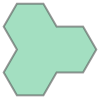

In [32]:
samplepoly = hex20_df.iloc[6].geometry
samplepoly